In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
# These packages are required by the visualization utils
import seaborn as sns  
from sklearn.manifold import TSNE

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


At first we need to get the MNIST dataset. Torch library has the MNIST dataset. Since we are using google colab, we can utilize the gpu function and work on "CUDA" device. So far in many of our courses, the DataLoader was used, so we will be using that too. For more info: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader


In [2]:
device = 'cuda'
# device = 'cpu'  # uncomment this line to run the model on the CPU
batch_size = 128
dataset = datasets.MNIST 
if device == 'cuda':
    train_loader = torch.utils.data.DataLoader(
        dataset('data', train=True, download=True, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True
    )
    test_loader = torch.utils.data.DataLoader(
        dataset('data', train=False, download=True, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True
    )
elif device == 'cpu':
    train_loader = torch.utils.data.DataLoader(
        dataset('data', train=True, download=True, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True,
    )
    test_loader = torch.utils.data.DataLoader(
        dataset('data', train=False, download=True, transform=transforms.ToTensor()),
        batch_size=1000, shuffle=True,
    )


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Now we check the first sample in training data. We can see that even though MNIST data set has color black and white the data is not actually binary. It is normalized between 0 and 1. Therefore we can use bernoulli for sampling for easiser to compute samples, or use gaussian (as asked).

In [3]:
temp_data = train_loader.dataset[1][0]
temp_data_class = train_loader.dataset[0][1]

print("First data sample in train data: ", temp_data)
print("First data samples class: ", temp_data_class)

First data sample in train data:  tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.000

This way of visualization does not help us see the number "5" though. So we will use a visualization function. For that we used the guide in https://medium.com/@mrdatascience/how-to-plot-mnist-digits-using-matplotlib-65a2e0cc068 and https://realpython.com/python-matplotlib-guide/
However, plt function only takes numpy arrays not tensors. So we will change our tensors to numpy before plotting them:


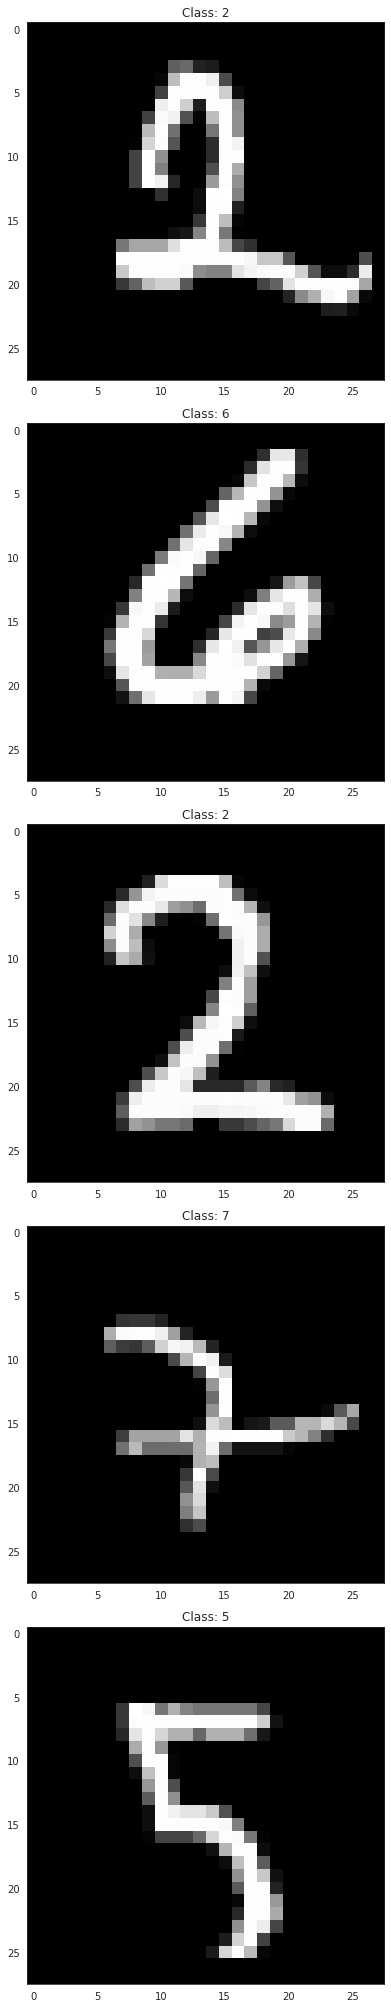

In [4]:
sns.set_style('white')
fig, axes = plt.subplots(5, figsize=(28, 28))
for i in range(5):
  ax = axes[i]
  idx = np.random.randint(len(train_loader.dataset))
  x = train_loader.dataset[idx][0].view(28, 28).cpu().numpy()#change to numpy otherwise imshow doesnt work
  y = train_loader.dataset[idx][1]
  ax.imshow(x, cmap='gray', vmin=0.0, vmax=1.0)
  ax.set_title(f'Class: {y}')
plt.tight_layout()
plt.show()

We can clearly see that the numbers are not binary in here either. The data seems to be loaded correctly so now we will start creating our Variational Auto Encoder class. The custom class will use nn layers. We will create it according to https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

Here are what we need:

1.   An encoder g that produces both mu and logsigma for reparametrization of latent variable z'. logsigma is written in 'thesis'. Check why?
LEARNED WHY:

1) We already need logsigma in KL term
2) Normally sigma is between the values 0 and 1, therefore when optimizing such a number, deep learning network works with lots of float point arithmetic. Therefore handling it in a log form is easier and less tasking!
https://stats.stackexchange.com/questions/353220/why-in-variational-auto-encoder-gaussian-variational-family-we-model-log-sig



2. Sample z'. z is drawn from standart normal and then z' = std*z + mu

However, there can be an alternate paramterization of z'. Check pages 24-25-26 from 'Thesis'.

3. KL term which has analytical solution if we have both distributions as multivarite gaussian
4. decoder network that gets z' and produces "ONLY" mean of x.
5. ELBO: putting the whole thing together.
6. Sampling function



In [5]:
def batch_diag(batched_variance):
    batch_shape = batched_variance.shape[:-1]
    event_size = batched_variance.size(-1)
    cov = batched_variance.new_zeros(batch_shape + (event_size * event_size,))
    cov[..., ::1 + event_size] = batched_variance
    return cov.reshape(batch_shape + (event_size, event_size))

In [7]:
class VAE(nn.Module):
  def __init__(self, batch_size, x_dim, latent_dim):
    super().__init__()
    self.x_dim = x_dim
    #self.x_shape = 0
    self.latent_dim = latent_dim
    self.batch_size = batch_size
    #self.l_std = likelihood_std
    #self.l_std = nn.Parameter(torch.ones(batch_size, x_dim, requires_grad=True))
    #self.l_std = torch.ones(batch_size, x_dim, requires_grad=False).to('cuda')
    self.l_std = nn.Parameter(torch.ones(x_dim, requires_grad=True))
    #self.l_std = nn.Parameter(torch.zeros(x_dim, requires_grad=True))
    

    self.encoder_1 = nn.Linear(x_dim, 256)

    self.encoder_2 = nn.Linear(256,256)

    self.encoder_mu = nn.Linear(256, latent_dim)
    self.encoder_sigma = nn.Linear(256, latent_dim)

    self.decoder_1 = nn.Linear(latent_dim,256)

    self.decoder_1_2 = nn.Linear(256,256)

    self.decoder_2 = nn.Linear(256,x_dim)
    self.decoder_3 = nn.Linear(256,x_dim) # turn this into a global parameter

  def encoder(self,x):
    x_relu = torch.relu(self.encoder_1(x))
    return self.encoder_mu(x_relu), self.encoder_sigma(x_relu)

  def latent_z_sampling(self, mu, logsigma):
    # So to be able to train the neural network, we need to do a reparametrization trick.
    # Instead of modeling z' directly, we will pick it from a standart normal distribution,
    # and then apply transformation according to values that we got from the NN.
    # https://pytorch.org/docs/master/tensors.html#torch.Tensor.normal_
    # we have logsigma so we will convert it to sigma and then do
    # z' = sigma * z + mu where * is element wise multip.
    
    z = torch.empty_like(mu).normal_(0., 1.)
    return z* torch.exp(logsigma) + mu

  def KL_divergence(self, mu, logsigma):
    #In thesis the KL divergence for two normal distributions is given as:
    # 1/2 (sum over L(sigma**2 + mu**2 - log(sigma**2)-1))
    return 0.5 * (torch.exp(logsigma * 2) + torch.pow(mu, 2) - 2*logsigma -1).sum(-1)
    

  def decoder(self, z):
    #what to use for activation???
    #lets use sigmoid for now to keep the mean within 0 and 1 (since all the values should be within that range too)
    z_relu = torch.relu(self.decoder_1(z))
    #return torch.sigmoid(self.decoder_2(z_relu)), torch.sigmoid(self.decoder_3(z_relu))
    return torch.sigmoid(self.decoder_2(z_relu))


  def ELBO(self,x):
    #self.x_shape = x.shape()
    mu, logsigma = self.encoder(x)
    z = self.latent_z_sampling(mu, logsigma)
    
    kl_divergence = self.KL_divergence(mu, logsigma)
    
    #l_mean, l_log_sigma = self.decoder(z)
    l_mean = self.decoder(z)
    #print("x shape ", x.shape)
    #print("z shape: ", z.shape)
    
    #print("likelihood mean shape: ", l_mean.shape)
    #print("likelihood sigma", self.l_std.shape)
    
    
    #likelihood = torch.empty_like(x).normal_(likelihood_mean, self.l_std)

    # log likelihood of gaussian is -N/2 ln(cov.) -1/2 (sum over n (x- mu)^2 / cov)
    #print(l_log_sigma.shape)
    #likelihood_dist = torch.distributions.MultivariateNormal(l_mean, likelihood_log_sigma)
    
    #x_new = likelihood_dist.sample()
    #print(x_new.shape)
    #print(x.shape)
    #neg_log_like = -likelihood_dist.log_prob(x_new) 
    #print(neg_log_like.shape)
    #print(neg_log_like.shape)
    #print(kl_divergence.shape)
    #x_new = likelihood_dist.sample()
    #
    #If you assume identity cov
    #neg_log_like = -F.mse_loss(x, l_mean, reduction='none').sum(-1):
    
    #TRY
    #neg_log_like = -F.binary_cross_entropy(l_mean, x, reduction='none').sum(-1) #for bernoulli
    #loss_rec = LOG_2_PI + logvar_x + (x - mu_x)**2 / (2*torch.exp(logvar_x))
    #print(l_log_sigma)
    #return
    #cov = torch.diag(likelihood_log_sigma)
    
    #clamped_l_std = self.l_std.sigmoid()
    #l_log_sigma = clamped_l_std.log()
    #print(self.l_std)
    
    #print("l_log_sigma: ", l_log_sigma)
    #print("l_std: ", self.l_std)
    #torch.clamp(self.l_std, min =0.0, max=1.0)
    
    #self.l_std = torch.sigmoid(self.l_std)
    #
    
    #l_sigma = torch.sigmoid(self.l_std).repeat(x.shape[0])
    #print(l_sigma)
    


    
    #print("log_sigma:", l_log_sigma)
    #print("l_mean:", l_mean.shape)
    #l_log_sigma = l_log_sigma.log()
    
    #
    cov_matrix = torch.diag(self.l_std.pow(2))
    #print("cov_matrix shape:", cov_matrix.shape)
    #print("cov_matrix:", cov_matrix)
    
    #
    batched_cov_matrix = cov_matrix.repeat(x.shape[0], 1, 1)
    
    #print("batched shape: ", batched_cov_matrix.shape)
    #print("Batched cov: ", batched_cov_matrix)

    m = torch.distributions.MultivariateNormal(l_mean,batched_cov_matrix)
    #m = torch.distributions.MultivariateNormal(l_mean,l_sigma)
    
    #x_rec = m.sample()  # should have shape (batch,784)
    #print(x_rec.shape)

    #### MINUS OR NOT?
    neg_log_like = m.log_prob(x)  # should be a scalar
    #print(neg_log_like)
    
    #return

    #l_log_sigma.clamp(min=1e-8)
    ##for log sigma use this:
    #neg_log_like = (-0.5*(2*l_log_sigma + ((x-l_mean)**2)/(torch.exp(l_log_sigma*2)))).sum(-1)
    #neg_log_like = neg_log_like.clamp(min = 1e-8)
    ##for normal sigma use this:
    #neg_log_like = (-0.5*(2*self.l_std.log() + ((x-l_mean)**2)/(self.l_std**2))).sum(-1)
    
    #print(l_mean.shape)
    #print(l_log_sigma.shape)
    #print(torch.diagonal(l_log_sigma).shape)
    #cov = batch_diag(l_log_sigma)
    
    #log_term =(l_log_sigma**2).log()
    #mean_term = (x-l_mean)**2
    #sigma_square = (l_log_sigma**2)
    #print("log term:", log_term)
    #print("mean term:", mean_term)
    #print("sigma term:",sigma_square)

    #neg_log_like = (-0.5 * (log_term + mean_term/sigma_square)).sum(-1)
    #neg_log_like = (-0.5*((l_log_sigma**2).log() + ((x - l_mean)**2)/(l_log_sigma**2))).sum(-1)
    #print("log like:", neg_log_like)
    #print("neg_log_like: ", neg_log_like.shape)
    #return
    return neg_log_like - kl_divergence
    #return -F.mse_loss(x,likelihood_mean) -kl_divergence

  def print_std(self):
    print(self.l_std)


  def reconstruced_images(self,x):
    mu, logsigma = self.encoder(x)
    z = self.latent_z_sampling(mu, logsigma)
    #l_mean, l_log_sigma = self.decoder(z)
    l_mean = self.decoder(z)
    
    l_log_sigma = self.l_std
    
    #print("l_log_sigma", l_log_sigma)
    
    #l_log_sigma = nn.Parameter(torch.zeros(self.x_dim, requires_grad=False)).to(device)
    
    reconstructed = torch.normal(l_mean, l_log_sigma)
    return x, reconstructed

  def sample_new(self, sample_num):
    z = torch.empty(sample_num, self.latent_dim).normal_().to(device)
    #likelihood_mean, l_log_sigma  = self.decoder(z)
    likelihood_mean = self.decoder(z)
    
    l_log_sigma = self.l_std
    #l_log_sigma = nn.Parameter(torch.zeros(self.x_dim, requires_grad=False)).to(device)
    
    #torch.empty(sample_num).normal_(mean=likelihood_mean,std=l_log_sigma)
    #return torch.empty(x_dim).normal_(likelihood_mean, self.l_std)
    #return torch.distributions.Normal(likelihood_mean, l_log_sigma)
    return torch.normal(likelihood_mean, l_log_sigma)




# Visualize samples Function:

In [8]:
def visualize_vae_samples(samples, num_rows=2, num_cols=5):
    """Plot random samples generated by the VAE.

    Args:
        samples: Samples drawn from the model, shape [num_samples, 28, 28]

    """
    sns.set_style('white')
    num_total = num_rows * num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.5 * num_cols, 2 * num_rows))
    for i in range(num_total):
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(samples[i], cmap='gray', vmin=0.0, vmax=1.0)
        ax.set_title(f'Sample #{i}')
    plt.tight_layout()
    plt.show()

# Visualize Embeddings Function:
We used the t-sne representation. https://distill.pub/2016/misread-tsne/ gives a good outlook on the tsne. The transformation is non-linear and adapts to data, therefore performs different transformations on different parts of data.
In sklearn documentation https://scikit-learn.org/0.15/modules/generated/sklearn.manifold.TSNE.html , it is said that pca is more stable than random init.

In [9]:
def visualize_embeddings(vae, x, y):
    sns.set_style('whitegrid')
    tsne = TSNE(perplexity=50.0, init='pca')
    # Obtain embeddings using VAE
    # The first output was mean, second one was log sigma
    means = vae.encoder(x)[0].cpu().detach().numpy()
    # Dimensionality reduction on the embeddings using t-SNE
    emb = tsne.fit_transform(means)

    plt.figure(figsize=[10, 7])
    labels = y.cpu().numpy()
    for l in np.unique(labels):
        class_ind = (labels == l)
        plt.scatter(emb[class_ind, 0], emb[class_ind, 1], label=f'{l}', alpha=0.5)
        plt.legend()
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    plt.show()

# New sample Visualization Wrapper Function:

In [10]:
def new_sample_wrapper(vae):
  x = vae.sample_new(15).view(-1, 28, 28).detach().cpu().numpy()
  visualize_vae_samples(x,3,5)

# Reconstructed sample Visualization Wrapper Function:

In [11]:
def sample_vis_wrapper(vae, test_loader, sample_number = 15):
  from numpy import save
  from numpy import asarray
  max_epochs = 1
  #sample_number = 15
  for epoch in range(max_epochs):
      print(f'Epoch {epoch}')
      for ix, batch in enumerate(test_loader):
          x, y = batch
          #print(x.shape)
          x = x.view(x.shape[0], x_dim).to(device)  # we flatten the image into 1D array
          #opt.zero_grad()
          # We want to maximize the ELBO, so we minimize the negative ELBO
          old_x, reconst_x = vae.reconstruced_images(x)
          old_x_sample = old_x[0:sample_number,].view(-1, 28, 28).detach().cpu().numpy()
          reconst_x_sample = reconst_x[0:sample_number,].view(-1, 28, 28).detach().cpu().numpy()
          visualize_vae_samples(old_x_sample,3,5)
          visualize_vae_samples(reconst_x_sample,3,5)
          break
  save('old_x_sample.npy', asarray(old_x_sample))
  save('reconst_x_sample.npy', asarray(reconst_x_sample))
        

# Embedding Visualization Wrapper Function:

In [12]:
def embedding_wrapper(vae, test_loader, obs_dim = 784):
  x, y = next(iter(test_loader))
  x = x.view(x.shape[0], obs_dim).to(device)
  plt.figure(figsize=[10, 7])
  visualize_embeddings(vae, x, y)

In [13]:
def loss_plot(loss_arr):
  plt.plot(loss_arr)
  plt.xlabel("Number of batch")
  plt.show("The loss value")

# The train function:

In [14]:
def train_func(vae, opt, train_loader, loss_arr, max_epochs = 50, display_step = 100):
  for epoch in range(max_epochs):
      print(f'Epoch {epoch}')
      for ix, batch in enumerate(train_loader):
          x, y = batch
          #print("x batch shape: ", x.shape)
          x = x.view(x.shape[0], x_dim).to(device)  # we flatten the image into 1D array
          
          # We want to maximize the ELBO, so we minimize the negative ELBO
          loss = -vae.ELBO(x).mean(-1)
          loss_arr = np.append(loss_arr, loss.item())
          loss.backward()
          opt.step()
          opt.zero_grad()
          if ix % display_step == 0:
              print(f'  loss = {loss.item():.2f}')
              #vae.print_std()
          
  #print(loss_arr)
  return loss_arr

# Create the model with desired parameters:

In [15]:
 # MNIST images are of shape [1, 28, 28]
x_dim = 28*28
latent_dim = 256  # Size of the latent variable z
#latent_dim = 32
#batch_size = 128
#likelihood_std = torch.eye(x_dim, requires_grad=True)
vae = VAE(batch_size, x_dim, latent_dim).to(device)

for name, param in vae.named_parameters():
  print(name)
  if param.device.type != 'cuda':
    print('param {}, not on GPU'.format(name))  

#print(vae.parameters())
opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

loss_arr = np.empty(0)

l_std
encoder_1.weight
encoder_1.bias
encoder_2.weight
encoder_2.bias
encoder_mu.weight
encoder_mu.bias
encoder_sigma.weight
encoder_sigma.bias
decoder_1.weight
decoder_1.bias
decoder_1_2.weight
decoder_1_2.bias
decoder_2.weight
decoder_2.bias
decoder_3.weight
decoder_3.bias


In [ ]:
"""test_sigma = torch.ones(10) +1 #.repeat(10)

a = test_sigma.pow(2)
print(test_sigma)
print(a)

test_mean = torch.ones(10).repeat(10)
test_sigma = torch.sigmoid(test_sigma)
print(test_sigma)
#test_cov = test_sigma.diag()
#print(test_cov)
#test_batch_cov = test_cov.repeat(10, 1,1)
#print(test_batch_cov)

m = torch.distributions.Normal(test_mean, test_sigma)
temp = m.sample()
log_prob = m.log_prob(temp)
"""

'test_sigma = torch.ones(10) +1 #.repeat(10)\n\na = test_sigma.pow(2)\nprint(test_sigma)\nprint(a)\n\ntest_mean = torch.ones(10).repeat(10)\ntest_sigma = torch.sigmoid(test_sigma)\nprint(test_sigma)\n#test_cov = test_sigma.diag()\n#print(test_cov)\n#test_batch_cov = test_cov.repeat(10, 1,1)\n#print(test_batch_cov)\n\nm = torch.distributions.Normal(test_mean, test_sigma)\ntemp = m.sample()\nlog_prob = m.log_prob(temp)\n'

# Train the model:

First epoch results:

In [ ]:
loss_arr = train_func(vae, opt, train_loader, loss_arr, 1)
print("The 15 samples generated: ")
new_sample_wrapper(vae)
print("The 15 samples reconstructed: ")
sample_vis_wrapper(vae, test_loader)
print("The Loss curve:")
loss_plot(loss_arr)
print("The latent representation using T-snes:")
embedding_wrapper(vae, test_loader)

Epoch 0
  loss = 814.84
  loss = 668.58


Fifth epoch results:

Epoch 0
  loss = 814.83
  loss = 669.98
  loss = 575.49
  loss = 463.95
  loss = 325.84
Epoch 1
  loss = 203.81
  loss = -37.78
  loss = -599.99
  loss = -919.45
  loss = -992.27
Epoch 2
  loss = -894.63
  loss = -1038.30
  loss = -998.68
  loss = 7474.18
  loss = -1039.49
Epoch 3
  loss = -1049.83
  loss = -848.10
  loss = -884.40
  loss = -1049.25
  loss = -1058.54
Epoch 4
  loss = -997.31
  loss = -1066.89
  loss = -973.46
  loss = -1035.71
  loss = -947.80
The 15 samples generated: 


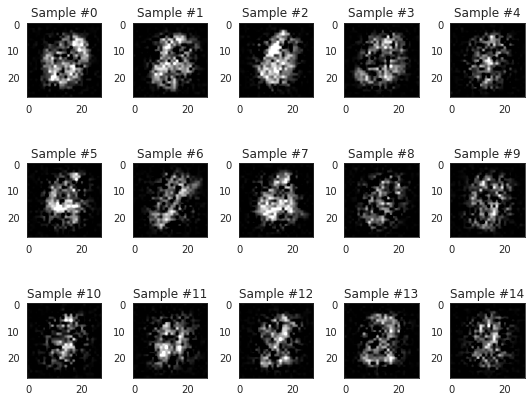

The 15 samples reconstructed: 
Epoch 0


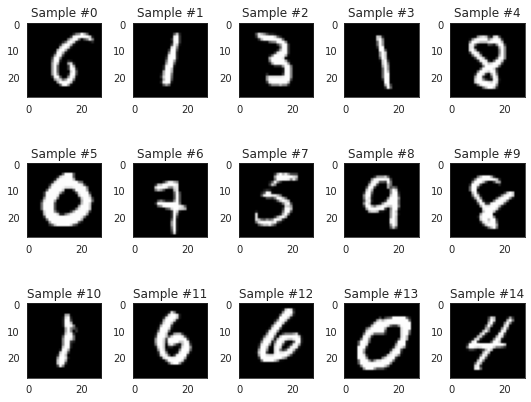

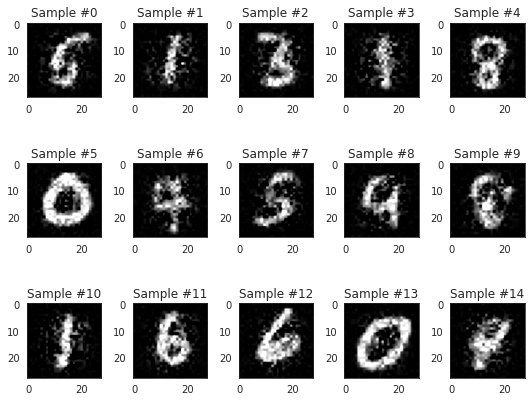

The Loss curve:


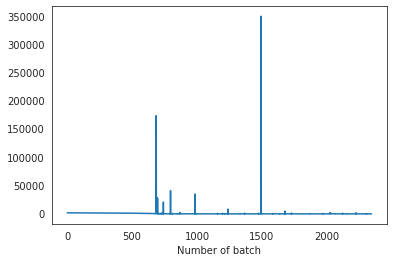

The latent representation using T-snes:


<Figure size 720x504 with 0 Axes>

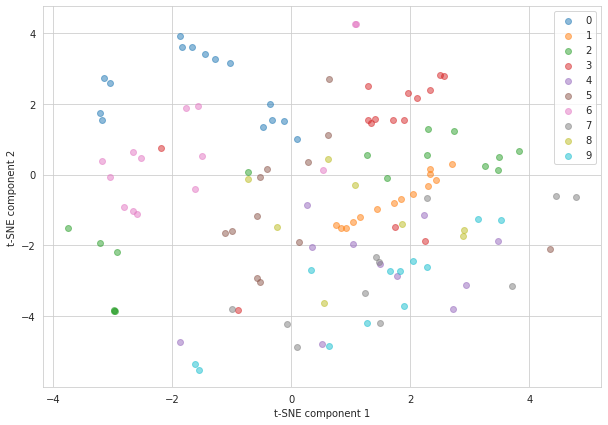

In [16]:
loss_arr = train_func(vae, opt, train_loader, loss_arr, 5)
print("The 15 samples generated: ")
new_sample_wrapper(vae)
print("The 15 samples reconstructed: ")
sample_vis_wrapper(vae, test_loader)
print("The Loss curve:")
loss_plot(loss_arr)
print("The latent representation using T-snes:")
embedding_wrapper(vae, test_loader)

25'th epoch results:

In [ ]:
loss_arr = train_func(vae, opt, train_loader, loss_arr, 17)
print("The 15 samples generated: ")
new_sample_wrapper(vae)
print("The 15 samples reconstructed: ")
sample_vis_wrapper(vae, test_loader)
print("The Loss curve:")
loss_plot(loss_arr)
print("The latent representation using T-snes:")
embedding_wrapper(vae, test_loader)

Epoch 0
  loss = -1108.98
  loss = -1125.88
  loss = -734.62
  loss = -1070.27
  loss = -1159.34
Epoch 1
  loss = -1138.07
  loss = -1170.52
  loss = -1136.26
  loss = -1108.77
  loss = -1074.64
Epoch 2
  loss = -1136.91
  loss = -575.69
  loss = -1056.14
  loss = -1124.90
  loss = -1117.01
Epoch 3
  loss = -1165.17
  loss = -996.37
  loss = -1169.55
  loss = -1113.81
  loss = -1079.22
Epoch 4
  loss = -334.82
  loss = -1062.64
  loss = -1062.16
  loss = -1150.66
  loss = -1144.12
Epoch 5
  loss = -797.83
  loss = -1096.02
  loss = -1061.20
  loss = -1073.88
  loss = -1159.94
Epoch 6
  loss = -1134.02
  loss = -1178.42
  loss = -1104.85
  loss = -1133.34
  loss = -1111.60
Epoch 7
  loss = -1207.67
  loss = -1120.89
  loss = -1165.29
  loss = -1168.54
  loss = -1172.63
Epoch 8
  loss = -153.37
  loss = -876.23
  loss = -999.99
  loss = -1110.41
  loss = -1133.23
Epoch 9
  loss = -1199.20
  loss = -1157.54
  loss = -1063.73


50'th epoch results(the loss function converges at 50th epoch):

In [ ]:
loss_arr = train_func(vae, opt, train_loader, loss_arr, 25)
print("The 15 samples generated: ")
new_sample_wrapper(vae)
print("The 15 samples reconstructed: ")
sample_vis_wrapper(vae, test_loader)
print("The Loss curve:")
loss_plot(loss_arr)
print("The latent representation using T-snes:")
embedding_wrapper(vae, test_loader)

In [ ]:
print(loss_arr)
results = loss_arr

In [ ]:
results = np.clip(results,a_min= -100000000, a_max = 1000)
loss_plot(results)

In [ ]:
"""max_epochs = 1
display_step = 100
for epoch in range(max_epochs):
    print(f'Epoch {epoch}')
    for ix, batch in enumerate(train_loader):
        x, y = batch
        #print("x batch shape: ", x.shape)
        x = x.view(x.shape[0], x_dim).to(device)  # we flatten the image into 1D array
        opt.zero_grad()
        # We want to maximize the ELBO, so we minimize the negative ELBO
        loss = -vae.ELBO(x).mean(-1)
        loss_arr = np.append(loss_arr, loss.item())
        loss.backward()
        opt.step()
        
        if ix % display_step == 0:
            print(f'  loss = {loss.item():.2f}')"""